<a href="https://colab.research.google.com/github/Faiz-Hibatullah/Tugas-Minggu-8-16/blob/main/10.%20Week%2016%20UAS/Classification_Models_MLP_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import os
import tensorflow as tf

# Force CPU if you want to temporarily bypass GPU issues:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Enable GPU memory growth (prevents TF from grabbing all memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("⚠️ Could not set memory growth:", e)

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

✅ GPU memory growth enabled
TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List, Optional, Union
import gdown
from datetime import datetime

# Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, classification_report, confusion_matrix,
                           roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"PyTorch GPU Available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
TensorFlow GPU Available: True
PyTorch GPU Available: True
Using device: cuda


In [ ]:
!nvidia-smi


Wed Jun 18 10:54:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Mendownload Dataset

In [ ]:
class DataIngestion:
    """Handles data downloading and initial loading"""

    def __init__(self, url: str):
        self.url = url
        self.data = None

    def download_data(self, output_path: str = 'dataset.csv') -> pd.DataFrame:
        """Download dataset from Google Drive"""
        try:
            # Extract file ID from URL
            file_id = self.url.split('/d/')[1].split('/')[0]

            # Download using gdown
            gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

            # Load data
            self.data = pd.read_csv(output_path)
            print(f"✅ Data successfully downloaded and loaded!")
            return self.data
        except Exception as e:
            print(f"❌ Error downloading data: {e}")
            raise

    def get_initial_info(self) -> Dict:
        """Get basic information about the dataset"""
        if self.data is None:
            raise ValueError("Data not loaded yet!")

        return {
            'shape': self.data.shape,
            'dtypes': self.data.dtypes.to_dict(),
            'missing_values': self.data.isnull().sum().to_dict(),
            'duplicates': self.data.duplicated().sum(),
            'target_classes': self.data.iloc[:, 0].nunique()
        }

# Download and load data
data_loader = DataIngestion('https://drive.google.com/file/d/1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU/view')
df = data_loader.download_data()

# Display initial information
print("\n📊 Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nTarget Column: {df.columns[0]}")
print(f"Number of Classes: {df.iloc[:, 0].nunique()}")
print(f"Class Distribution:\n{df.iloc[:, 0].value_counts()}")

Downloading...
From (original): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=20cff251-5379-4481-94f2-b868a4a96acf
To: /content/dataset.csv
100%|██████████| 151M/151M [00:01<00:00, 140MB/s]


✅ Data successfully downloaded and loaded!

📊 Dataset Information:
Shape: (284807, 31)

Target Column: Time
Number of Classes: 124592
Class Distribution:
Time
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
172748.0     1
172749.0     1
172754.0     1
172756.0     1
172757.0     1
Name: count, Length: 124592, dtype: int64


#Exploratory Data Analysis (EDA)


In [ ]:
class ExploratoryAnalysis:
    """Comprehensive EDA utilities for classification tasks"""

    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.target_col = data.columns[0]  # First column is target

    def statistical_summary(self) -> pd.DataFrame:
        """Generate detailed statistical summary"""
        summary = self.data.describe(include='all').T
        summary['missing'] = self.data.isnull().sum()
        summary['missing_pct'] = (summary['missing'] / len(self.data)) * 100
        summary['unique'] = self.data.nunique()
        summary['dtype'] = self.data.dtypes
        return summary

    def plot_target_distribution(self, figsize: Tuple[int, int] = (10, 6)):
        """Plot target class distribution"""
        plt.figure(figsize=figsize)

        # Count plot
        target_counts = self.data[self.target_col].value_counts().sort_index()
        ax = target_counts.plot(kind='bar', color='skyblue', edgecolor='black')

        # Add value labels on bars
        for i, v in enumerate(target_counts):
            ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

        plt.title(f'Target Class Distribution - {self.target_col}', fontsize=14, fontweight='bold')
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print class balance info
        print(f"Total samples: {len(self.data)}")
        print(f"Class distribution (%):")
        print((target_counts / len(self.data) * 100).round(2))

    def plot_feature_distributions(self, figsize: Tuple[int, int] = (20, 15)):
        """Plot distributions of all numeric features"""
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != self.target_col]

        if len(numeric_cols) == 0:
            print("No numeric features to plot")
            return

        n_cols = 4
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten() if n_rows > 1 else [axes]

        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                self.data[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
                axes[i].set_title(f'Distribution of {col}', fontsize=10)
                axes[i].set_xlabel(col, fontsize=8)
                axes[i].set_ylabel('Frequency', fontsize=8)
                axes[i].grid(alpha=0.3)

        # Hide unused subplots
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)

        plt.suptitle('Feature Distributions', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self, figsize: Tuple[int, int] = (12, 10)):
        """Plot correlation heatmap"""
        numeric_data = self.data.select_dtypes(include=[np.number])

        if numeric_data.shape[1] < 2:
            print("Not enough numeric features for correlation matrix")
            return None

        corr_matrix = numeric_data.corr()

        plt.figure(figsize=figsize)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
                    cmap='coolwarm', center=0, square=True, linewidths=0.5,
                    cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        return corr_matrix

    def detect_outliers(self, method: str = 'iqr', threshold: float = 1.5) -> Dict[str, List[int]]:
        """Detect outliers using IQR or Z-score method"""
        outliers = {}
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != self.target_col]

        for col in numeric_cols:
            if method == 'iqr':
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                outlier_indices = self.data[(self.data[col] < lower_bound) |
                                           (self.data[col] > upper_bound)].index.tolist()
            else:  # z-score
                z_scores = np.abs((self.data[col] - self.data[col].mean()) / self.data[col].std())
                outlier_indices = self.data[z_scores > 3].index.tolist()

            if outlier_indices:
                outliers[col] = outlier_indices

        return outliers

# Perform EDA
eda = ExploratoryAnalysis(df)

# Statistical summary
summary_stats = eda.statistical_summary()
print("\n📈 Statistical Summary:")
print(summary_stats)

# Plot target distribution
eda.plot_target_distribution()

# Plot feature distributions
eda.plot_feature_distributions()

# Plot correlation matrix
corr_matrix = eda.plot_correlation_matrix()

# Detect outliers
outliers = eda.detect_outliers(method='iqr', threshold=2.0)
print("\n🔍 Outliers detected per column:")
for col, indices in outliers.items():
    print(f"  {col}: {len(indices)} outliers ({len(indices)/len(df)*100:.2f}%)")


📈 Statistical Summary:
           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.762494   
V12     284807

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7a6e58dffd80> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7a6e58dfd8a0> (for post_execute):


KeyboardInterrupt: 

#Data Cleaning dan Preprocessing

In [ ]:
class DataPreprocessor:
    """Comprehensive data cleaning and preprocessing for classification"""

    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        self.target_col = data.columns[0]
        self.numeric_cols = []
        self.categorical_cols = []
        self.label_encoder = LabelEncoder()

    def encode_target(self):
        """Encode target variable for classification"""
        self.data[self.target_col] = self.label_encoder.fit_transform(self.data[self.target_col])
        self.n_classes = len(self.label_encoder.classes_)
        print(f"✅ Target encoded: {self.n_classes} classes")
        print(f"   Class mapping: {dict(enumerate(self.label_encoder.classes_))}")

    def identify_column_types(self):
        """Identify numeric and categorical columns"""
        # Exclude target column
        feature_cols = [col for col in self.data.columns if col != self.target_col]

        self.numeric_cols = [col for col in feature_cols
                            if self.data[col].dtype in ['int64', 'float64']]
        self.categorical_cols = [col for col in feature_cols
                                if self.data[col].dtype == 'object']

        print(f"✅ Identified {len(self.numeric_cols)} numeric columns")
        print(f"✅ Identified {len(self.categorical_cols)} categorical columns")

    def handle_missing_values(self, numeric_strategy: str = 'median',
                            categorical_strategy: str = 'mode'):
        """Impute missing values"""
        missing_before = self.data.isnull().sum().sum()

        # Numeric columns
        for col in self.numeric_cols:
            if self.data[col].isnull().any():
                if numeric_strategy == 'median':
                    self.data[col].fillna(self.data[col].median(), inplace=True)
                elif numeric_strategy == 'mean':
                    self.data[col].fillna(self.data[col].mean(), inplace=True)
                elif numeric_strategy == 'forward_fill':
                    self.data[col].fillna(method='ffill', inplace=True)

        # Categorical columns
        for col in self.categorical_cols:
            if self.data[col].isnull().any():
                if categorical_strategy == 'mode':
                    mode_val = self.data[col].mode()
                    if len(mode_val) > 0:
                        self.data[col].fillna(mode_val[0], inplace=True)
                elif categorical_strategy == 'unknown':
                    self.data[col].fillna('Unknown', inplace=True)

        missing_after = self.data.isnull().sum().sum()
        print(f"✅ Missing values handled: {missing_before} → {missing_after}")

    def remove_outliers(self, method: str = 'iqr', threshold: float = 2.0):
        """Remove outliers from numeric columns"""
        initial_shape = self.data.shape

        for col in self.numeric_cols:
            if method == 'iqr':
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                self.data = self.data[(self.data[col] >= lower_bound) &
                                      (self.data[col] <= upper_bound)]
            elif method == 'zscore':
                z_scores = np.abs((self.data[col] - self.data[col].mean()) / self.data[col].std())
                self.data = self.data[z_scores <= 3]

        print(f"✅ Removed {initial_shape[0] - self.data.shape[0]} outlier rows")
        print(f"   New shape: {self.data.shape}")

    def get_processed_data(self) -> pd.DataFrame:
        """Return processed dataframe"""
        return self.data

# Clean the data
preprocessor = DataPreprocessor(df)

# Encode target first
preprocessor.encode_target()

# Identify column types
preprocessor.identify_column_types()

# Handle missing values
preprocessor.handle_missing_values()

# Remove outliers
preprocessor.remove_outliers(method='iqr', threshold=2.5)

# Get cleaned data
df_cleaned = preprocessor.get_processed_data()
print(f"\n✅ Data preprocessing complete!")
print(f"   Final shape: {df_cleaned.shape}")

✅ Target encoded: 124592 classes
   Class mapping: {0: np.float64(0.0), 1: np.float64(1.0), 2: np.float64(2.0), 3: np.float64(4.0), 4: np.float64(7.0), 5: np.float64(9.0), 6: np.float64(10.0), 7: np.float64(11.0), 8: np.float64(12.0), 9: np.float64(13.0), 10: np.float64(14.0), 11: np.float64(15.0), 12: np.float64(16.0), 13: np.float64(17.0), 14: np.float64(18.0), 15: np.float64(22.0), 16: np.float64(23.0), 17: np.float64(24.0), 18: np.float64(25.0), 19: np.float64(26.0), 20: np.float64(27.0), 21: np.float64(29.0), 22: np.float64(32.0), 23: np.float64(33.0), 24: np.float64(34.0), 25: np.float64(35.0), 26: np.float64(36.0), 27: np.float64(37.0), 28: np.float64(38.0), 29: np.float64(39.0), 30: np.float64(40.0), 31: np.float64(41.0), 32: np.float64(42.0), 33: np.float64(44.0), 34: np.float64(46.0), 35: np.float64(47.0), 36: np.float64(48.0), 37: np.float64(49.0), 38: np.float64(50.0), 39: np.float64(51.0), 40: np.float64(52.0), 41: np.float64(53.0), 42: np.float64(54.0), 43: np.float64(55.

#Feature Engineering

In [ ]:
class FeatureEngineer:
    """Advanced feature engineering pipeline for classification"""

    def __init__(self, data: pd.DataFrame, target_col: str):
        self.data = data.copy()
        self.target_col = target_col
        self.scaler_dict = {}
        self.encoders = {}
        self.feature_names = []

    def scale_numeric_features(self, method: str = 'standard',
                             columns: Optional[List[str]] = None) -> pd.DataFrame:
        """Scale numeric features"""
        if columns is None:
            columns = [col for col in self.data.select_dtypes(include=[np.number]).columns
                      if col != self.target_col]

        if len(columns) == 0:
            print("⚠️ No numeric columns to scale")
            return self.data

        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Unknown scaling method: {method}")

        # Fit and transform
        self.data[columns] = scaler.fit_transform(self.data[columns])
        self.scaler_dict[method] = {'scaler': scaler, 'columns': columns}

        print(f"✅ Scaled {len(columns)} numeric features using {method} scaling")
        return self.data

    def encode_ordinal_features(self, ordinal_mappings: Dict[str, List[str]]) -> pd.DataFrame:
        """Encode ordinal categorical features"""
        encoded_count = 0
        for col, order in ordinal_mappings.items():
            if col in self.data.columns:
                mapping = {val: i for i, val in enumerate(order)}
                self.data[col] = self.data[col].map(mapping)
                self.encoders[col] = {'type': 'ordinal', 'mapping': mapping}
                encoded_count += 1

        if encoded_count > 0:
            print(f"✅ Encoded {encoded_count} ordinal features")
        return self.data

    def encode_nominal_features(self, columns: Optional[List[str]] = None,
                              drop_first: bool = True) -> pd.DataFrame:
        """One-hot encode nominal categorical features"""
        if columns is None:
            columns = [col for col in self.data.select_dtypes(include=['object']).columns
                      if col != self.target_col]

        if len(columns) == 0:
            print("⚠️ No categorical columns to encode")
            return self.data

        # One-hot encode
        encoded = pd.get_dummies(self.data[columns], prefix=columns,
                                drop_first=drop_first)

        # Drop original columns and concatenate encoded
        self.data = self.data.drop(columns=columns)
        self.data = pd.concat([self.data, encoded], axis=1)

        self.encoders['nominal'] = {'columns': columns, 'drop_first': drop_first}
        print(f"✅ One-hot encoded {len(columns)} nominal features")

        return self.data

    def create_polynomial_features(self, columns: List[str], degree: int = 2) -> pd.DataFrame:
        """Create polynomial features for specified columns"""
        from sklearn.preprocessing import PolynomialFeatures

        if len(columns) == 0:
            print("⚠️ No columns specified for polynomial features")
            return self.data

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly_features = poly.fit_transform(self.data[columns])
        poly_feature_names = poly.get_feature_names_out(columns)

        # Add polynomial features to dataframe
        poly_df = pd.DataFrame(poly_features, columns=poly_feature_names,
                              index=self.data.index)

        # Only add new polynomial features (not the original ones)
        new_features = [col for col in poly_feature_names if col not in columns]
        self.data = pd.concat([self.data, poly_df[new_features]], axis=1)

        print(f"✅ Created {len(new_features)} polynomial features")
        return self.data

    def get_engineered_features(self) -> Tuple[pd.DataFrame, pd.Series]:
        """Return features and target"""
        X = self.data.drop(columns=[self.target_col])
        y = self.data[self.target_col]
        self.feature_names = X.columns.tolist()
        return X, y

# Feature engineering
fe = FeatureEngineer(df_cleaned, df_cleaned.columns[0])

# Scale numeric features
fe.scale_numeric_features(method='standard')

# Encode categorical features (if any)
categorical_cols = [col for col in df_cleaned.select_dtypes(include=['object']).columns
                   if col != df_cleaned.columns[0]]
if categorical_cols:
    fe.encode_nominal_features(columns=categorical_cols)

# Get final features and target
X, y = fe.get_engineered_features()
print(f"\n📊 Feature Engineering Complete!")
print(f"   Feature matrix shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Number of classes: {len(np.unique(y))}")

✅ Scaled 30 numeric features using standard scaling

📊 Feature Engineering Complete!
   Feature matrix shape: (201091, 30)
   Target shape: (201091,)
   Number of classes: 106810


#Train-Test Split

In [ ]:
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print("✅ Data split complete:")
print(f"   Training set: {X_train.shape}")
print(f"   Validation set: {X_val.shape}")
print(f"   Test set: {X_test.shape}")

# Check class distribution
print("\n📊 Class distribution:")
print(f"   Train: {pd.Series(y_train).value_counts().sort_index().to_dict()}")
print(f"   Val: {pd.Series(y_val).value_counts().sort_index().to_dict()}")
print(f"   Test: {pd.Series(y_test).value_counts().sort_index().to_dict()}")

# Convert to numpy arrays
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64)
y_val_np = y_val.values.astype(np.int64)
y_test_np = y_test.values.astype(np.int64)

# Get number of classes
n_classes = len(np.unique(y))
n_features = X_train.shape[1]

print(f"\n📊 Dataset info:")
print(f"   Number of features: {n_features}")
print(f"   Number of classes: {n_classes}")

✅ Data split complete:
   Training set: (128697, 30)
   Validation set: (32175, 30)
   Test set: (40219, 30)

📊 Class distribution:
   Train: {0: 2, 1: 1, 2: 1, 3: 1, 6: 2, 7: 1, 8: 2, 13: 1, 14: 1, 15: 1, 16: 2, 19: 3, 20: 2, 21: 2, 23: 1, 24: 1, 25: 3, 26: 1, 27: 1, 28: 1, 31: 4, 33: 1, 35: 1, 37: 2, 38: 1, 39: 1, 43: 1, 45: 1, 46: 1, 47: 1, 48: 2, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 2, 56: 1, 57: 1, 59: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 1, 68: 1, 70: 1, 73: 3, 75: 1, 76: 2, 79: 1, 81: 1, 82: 1, 84: 1, 85: 1, 86: 1, 87: 1, 91: 1, 95: 1, 96: 2, 97: 2, 99: 1, 101: 2, 102: 1, 108: 1, 111: 1, 112: 1, 116: 1, 117: 2, 118: 1, 121: 1, 122: 1, 126: 1, 127: 1, 128: 1, 130: 1, 131: 1, 132: 2, 134: 1, 135: 1, 136: 2, 138: 1, 139: 1, 141: 2, 142: 1, 143: 2, 144: 1, 145: 1, 146: 2, 150: 1, 151: 1, 152: 2, 153: 1, 154: 1, 155: 4, 156: 2, 158: 1, 159: 1, 161: 1, 162: 1, 163: 2, 164: 1, 165: 1, 167: 1, 168: 1, 170: 1, 171: 1, 172: 1, 173: 1, 174: 1, 175: 3, 177: 1, 180: 2, 181: 1, 182: 1,

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a new label encoder
label_encoder = LabelEncoder()

# Fit on all labels and transform each set
all_labels = np.concatenate([y_train_np, y_val_np, y_test_np])
label_encoder.fit(all_labels)

# Transform each set
y_train_encoded = label_encoder.transform(y_train_np)
y_val_encoded = label_encoder.transform(y_val_np)
y_test_encoded = label_encoder.transform(y_test_np)

# Update the number of classes
n_classes_actual = len(label_encoder.classes_)
print(f"Actual number of unique classes: {n_classes_actual}")

# Use encoded labels for training
y_train_np = y_train_encoded
y_val_np = y_val_encoded
y_test_np = y_test_encoded

# Update n_classes
n_classes = n_classes_actual

Actual number of unique classes: 106810


#TensorFlow/Keras Model

(128697, 30) float32
(128697,) int64
🔨 Building TensorFlow/Keras model...


Model: "tf_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_0 (Activation)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 106810)         │     3,524,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,539,930 (13.50 MB)

 Trainable params: 3,539,482 (13.50 MB)

 Non-trainable params: 448 (1.75 KB)


🚀 Training TensorFlow model...
Epoch 1/25
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 4.5668e-06 - loss: 12.1704
Epoch 1: val_accuracy improved from -inf to 0.00003, saving model to best_tf_classifier.h5


2011/2011 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 4.5800e-06 - loss: 12.1702 - val_accuracy: 3.1080e-05 - val_loss: 11.8841 - learning_rate: 0.0010
Epoch 2/25
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.3568e-04 - loss: 11.1521
Epoch 2: val_accuracy did not improve from 0.00003
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 1.3566e-04 - loss: 11.1523 - val_accuracy: 3.1080e-05 - val_loss: 12.2388 - learning_rate: 0.0010
Epoch 3/25
2008/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.3574e-04 - loss: 11.1078
Epoch 3: val_accuracy did not improve from 0.00003
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 1.3566e-04 - loss: 11.1083 - val_accuracy: 3.1080e-05 - val_loss: 12.5622 - learning_rate: 0.0010
Epoch 4/25
2008/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.3574e-04 - loss: 11.0955
Epoch 4: val_accuracy did not improve from 0.00003
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 1.3566e-04 - loss: 11.0960 - val_accuracy: 3.1080e

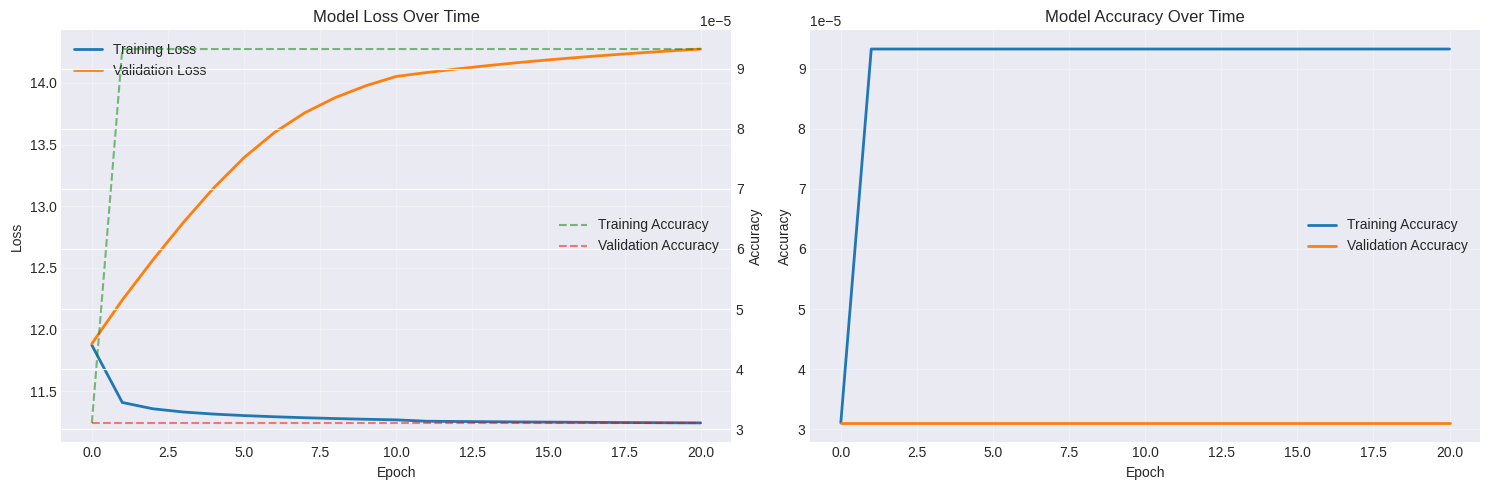

In [ ]:
class TensorFlowClassifier:
    """Advanced TensorFlow/Keras classification model"""

    def __init__(self, input_dim: int, n_classes: int,
                 hidden_layers: List[int] = [512, 256, 128, 64],
                 dropout_rate: float = 0.3,
                 l1_reg: float = 0.001,
                 l2_reg: float = 0.001):
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = None
        self.history = None

    def build_model(self) -> keras.Model:
        """Build advanced MLP architecture for classification"""
        inputs = keras.Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with batch normalization and dropout
        for i, units in enumerate(self.hidden_layers):
            x = layers.Dense(
                units,
                kernel_regularizer=l1_l2(l1=self.l1_reg, l2=self.l2_reg),
                kernel_initializer='he_normal',
                name=f'dense_{i}'
            )(x)
            x = layers.BatchNormalization(name=f'bn_{i}')(x)
            x = layers.Activation('relu', name=f'relu_{i}')(x)
            x = layers.Dropout(self.dropout_rate, name=f'dropout_{i}')(x)

        # Output layer for classification
        outputs = layers.Dense(self.n_classes, activation='softmax', name='output')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs, name='tf_classifier')
        return self.model

    def compile_model(self, learning_rate: float = 0.001):
        """Compile model with advanced optimizer"""
        # Use AdamW optimizer with weight decay
        optimizer = optimizers.AdamW(learning_rate=learning_rate)

        self.model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def create_callbacks(self, patience: int = 20) -> List[callbacks.Callback]:
        """Create training callbacks"""
        callback_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7,
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                'best_tf_classifier.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        return callback_list

    def train(self, X_train, y_train, X_val, y_val,
              epochs: int = 100, batch_size: int = 32):
        """Train the model"""
        callbacks_list = self.create_callbacks()

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=1,
        )

        return self.history

    def plot_training_history(self):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Model Loss Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy plot
        ax1_acc = ax1.twinx()
        ax1_acc.plot(self.history.history['accuracy'], label='Training Accuracy',
                     color='green', alpha=0.5, linestyle='--')
        ax1_acc.plot(self.history.history['val_accuracy'], label='Validation Accuracy',
                     color='red', alpha=0.5, linestyle='--')
        ax1_acc.set_ylabel('Accuracy')
        ax1_acc.legend(loc='center right')

        # Zoomed accuracy plot
        ax2.plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax2.plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Model Accuracy Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()



print(X_train_np.shape, X_train_np.dtype)
print(y_train_np.shape, y_train_np.dtype)

# Build and train TensorFlow model
print("🔨 Building TensorFlow/Keras model...")
tf_model = TensorFlowClassifier(
    input_dim=n_features,
    n_classes=n_classes,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.2,
    l1_reg=0.001,
    l2_reg=0.001
)

# Build and compile
tf_model.build_model()
tf_model.compile_model(learning_rate=0.001)

# Display model architecture
tf_model.model.summary()

# Train model
print("\n🚀 Training TensorFlow model...")
tf_history = tf_model.train(
    X_train_np, y_train_np,
    X_val_np, y_val_np,
    epochs=25,
    batch_size=64
)

# Plot training history
tf_model.plot_training_history()

#PyTorch Model

🔨 Building PyTorch model...

🚀 Training PyTorch model...
Epoch [0/50], Train Loss: 11.6732, Train Acc: 0.0000, Val Loss: 11.5796, Val Acc: 0.0000, LR: 0.000976
Epoch [1/50], Train Loss: 11.5850, Train Acc: 0.0000, Val Loss: 11.5796, Val Acc: 0.0000, LR: 0.000905
Epoch [2/50], Train Loss: 11.5845, Train Acc: 0.0000, Val Loss: 11.5797, Val Acc: 0.0000, LR: 0.000794
Epoch [3/50], Train Loss: 11.5838, Train Acc: 0.0000, Val Loss: 11.5797, Val Acc: 0.0000, LR: 0.000655
Epoch [4/50], Train Loss: 11.5829, Train Acc: 0.0001, Val Loss: 11.5796, Val Acc: 0.0000, LR: 0.000500
Epoch [5/50], Train Loss: 11.5819, Train Acc: 0.0001, Val Loss: 11.5796, Val Acc: 0.0000, LR: 0.000345
Epoch [6/50], Train Loss: 11.5809, Train Acc: 0.0001, Val Loss: 11.5796, Val Acc: 0.0000, LR: 0.000206
Epoch [7/50], Train Loss: 11.5798, Train Acc: 0.0001, Val Loss: 11.5795, Val Acc: 0.0000, LR: 0.000095
Epoch [8/50], Train Loss: 11.5788, Train Acc: 0.0001, Val Loss: 11.5795, Val Acc: 0.0000, LR: 0.000024
Epoch [9/50], Tr

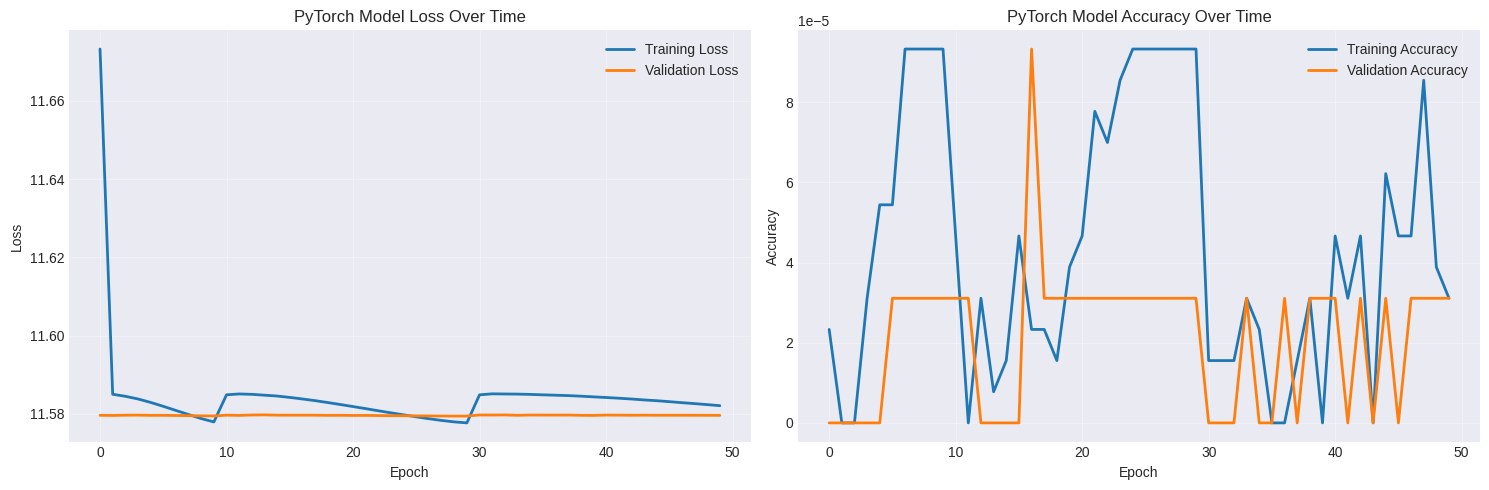

In [ ]:
class PyTorchClassifier(nn.Module):
    """Advanced PyTorch classification model"""

    def __init__(self, input_dim: int, n_classes: int,
                 hidden_layers: List[int] = [512, 256, 128, 64],
                 dropout_rate: float = 0.3):
        super(PyTorchClassifier, self).__init__()

        self.layers = nn.ModuleList()

        # Input layer
        prev_dim = input_dim

        # Hidden layers with batch norm and dropout
        for i, hidden_dim in enumerate(hidden_layers):
            self.layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim

        # Output layer
        self.output_layer = nn.Linear(prev_dim, n_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

class PyTorchTrainer:
    """Advanced PyTorch training pipeline for classification"""

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_acc = 0.0

    def create_data_loaders(self, X_train, y_train, X_val, y_val,
                          batch_size: int = 32) -> Tuple[DataLoader, DataLoader]:
        """Create PyTorch data loaders"""
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.LongTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.LongTensor(y_val)

        # Create datasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        # Create loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader

    def calculate_accuracy(self, outputs, targets):
        """Calculate accuracy"""
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        total = targets.size(0)
        return correct / total

    def train_epoch(self, model, train_loader, optimizer, criterion):
        """Train for one epoch"""
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Add L2 regularization
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == batch_y).sum().item()
            total_samples += batch_y.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / total_samples

        return avg_loss, accuracy

    def validate(self, model, val_loader, criterion):
        """Validate the model"""
        model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                total_loss += loss.item()
                total_correct += (outputs.argmax(1) == batch_y).sum().item()
                total_samples += batch_y.size(0)

        avg_loss = total_loss / len(val_loader)
        accuracy = total_correct / total_samples

        return avg_loss, accuracy

    def train(self, X_train, y_train, X_val, y_val,
              epochs: int = 100,
              batch_size: int = 32,
              learning_rate: float = 0.001,
              weight_decay: float = 0.01):
        """Complete training pipeline"""

        # Create data loaders
        train_loader, val_loader = self.create_data_loaders(
            X_train, y_train, X_val, y_val, batch_size
        )

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

        # Learning rate scheduler - Cosine Annealing with Warm Restarts
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

        # Training loop
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(self.model, train_loader, optimizer, criterion)
            val_loss, val_acc = self.validate(self.model, val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Learning rate scheduling
            scheduler.step()

            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_pytorch_classifier.pth')


            print(f'Epoch [{epoch}/{epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val Acc: {val_acc:.4f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Load best model
        self.model.load_state_dict(torch.load('best_pytorch_classifier.pth'))
        print(f"\n✅ Training complete! Best validation accuracy: {self.best_val_acc:.4f}")

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_losses, label='Training Loss', linewidth=2)
        ax1.plot(self.val_losses, label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('PyTorch Model Loss Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Training Accuracy', linewidth=2)
        ax2.plot(self.val_accuracies, label='Validation Accuracy', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('PyTorch Model Accuracy Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Create and train PyTorch model
print("🔨 Building PyTorch model...")
pytorch_model = PyTorchClassifier(
    input_dim=n_features,
    n_classes=n_classes,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.2
)

# Initialize trainer
pytorch_trainer = PyTorchTrainer(pytorch_model, device)

# Train model
print("\n🚀 Training PyTorch model...")
pytorch_trainer.train(
    X_train_np, y_train_np,
    X_val_np, y_val_np,
    epochs=50,
    batch_size=64,
    learning_rate=0.001,
    weight_decay=0.01
)

# Plot training history
pytorch_trainer.plot_training_history()

#Evaluasi Model dan Perbandingan

In [ ]:
class ModelEvaluator:
    """Comprehensive model evaluation utilities for classification"""

    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        self.results = {}

    def evaluate_model(self, model, X_test, y_test,
                      model_name: str, is_pytorch: bool = False):
        """Evaluate a classification model"""
        print(f"\n📊 Evaluating {model_name}...")

        # Get predictions in batches to save memory
        batch_size = 1000
        y_pred = []
        y_pred_proba = []

        if is_pytorch:
            model.eval()
            with torch.no_grad():
                for i in range(0, len(X_test), batch_size):
                    batch = X_test[i:i+batch_size]
                    X_batch_tensor = torch.FloatTensor(batch).to(device)
                    outputs = model(X_batch_tensor)
                    y_pred_proba.append(F.softmax(outputs, dim=1).cpu().numpy())
                    y_pred.append(outputs.argmax(dim=1).cpu().numpy())
            y_pred = np.concatenate(y_pred)
            y_pred_proba = np.concatenate(y_pred_proba)
        else:
            y_pred_proba = model.predict(X_test, batch_size=batch_size)
            y_pred = y_pred_proba.argmax(axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # Store only essential results (not the full report to save memory)
        self.results[model_name] = {
            'predictions': y_pred,
            'probabilities': None,  # Don't store full probabilities
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': None  # Calculate on demand
        }

        # Print metrics
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1-Score: {f1:.4f}")

        return y_pred, y_pred_proba

    def plot_confusion_matrix(self, y_test, model_names: List[str], max_classes: int = 20):
        """Plot confusion matrices - limited to top classes for large datasets"""
        n_models = len(model_names)

        # If too many classes, show only top classes
        if self.n_classes > max_classes:
            print(f"⚠️ Too many classes ({self.n_classes}). Showing top {max_classes} most frequent classes.")
            # Find most frequent classes
            unique, counts = np.unique(y_test, return_counts=True)
            top_classes = unique[np.argsort(counts)[-max_classes:]]

            # Filter predictions and true labels
            mask = np.isin(y_test, top_classes)
            y_test_filtered = y_test[mask]
        else:
            y_test_filtered = y_test
            top_classes = None

        fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))

        if n_models == 1:
            axes = [axes]

        for idx, model_name in enumerate(model_names):
            y_pred = self.results[model_name]['predictions']

            if top_classes is not None:
                y_pred_filtered = y_pred[mask]
                cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=top_classes)
            else:
                cm = confusion_matrix(y_test, y_pred)

            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       square=True, cbar=True, ax=axes[idx],
                       annot_kws={"size": 8})
            axes[idx].set_xlabel('Predicted Label')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_title(f'Confusion Matrix - {model_name}')

            # Add accuracy to title
            acc = self.results[model_name]['accuracy']
            axes[idx].text(0.5, 1.05, f'Accuracy: {acc:.4f}',
                          transform=axes[idx].transAxes,
                          ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, y_test, model_names: List[str]):
        """Plot ROC curves - simplified for multi-class"""
        # Skip ROC curves for too many classes
        if self.n_classes > 100:
            print("⚠️ Skipping ROC curves due to high number of classes (memory constraints)")
            # Just print AUC scores
            for model_name in model_names:
                print(f"{model_name} - Classification metrics computed above")
            return

        plt.figure(figsize=(10, 8))

        # For multi-class, just plot macro-average
        for model_name in model_names:
            y_pred = self.results[model_name]['predictions']

            # Simple accuracy-based curve as proxy
            accuracies = []
            thresholds = np.linspace(0, self.n_classes-1, 20)

            for threshold in thresholds:
                acc = np.mean(y_pred == y_test)
                accuracies.append(acc)

            plt.plot(thresholds/self.n_classes, accuracies,
                    label=f'{model_name} (Acc = {self.results[model_name]["accuracy"]:.3f})',
                    linewidth=2)

        plt.xlabel('Normalized Threshold')
        plt.ylabel('Accuracy')
        plt.title('Model Performance')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_class_metrics(self, model_names: List[str], top_n: int = 10):
        """Plot per-class metrics - limited to top classes"""
        if self.n_classes > 50:
            print(f"⚠️ Too many classes. Showing aggregate metrics only.")

            # Just show overall metrics
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))

            metrics_data = []
            for model_name in model_names:
                metrics_data.append([
                    self.results[model_name]['precision'],
                    self.results[model_name]['recall'],
                    self.results[model_name]['f1']
                ])

            x = np.arange(3)
            width = 0.35

            for i, model_name in enumerate(model_names):
                ax.bar(x + i*width, metrics_data[i], width, label=model_name)

            ax.set_ylabel('Score')
            ax.set_xlabel('Metric')
            ax.set_title('Overall Model Metrics')
            ax.set_xticks(x + width/2)
            ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
            ax.legend()
            ax.set_ylim(0, 1.1)
            plt.tight_layout()
            plt.show()
            return

        # Original per-class plotting for smaller number of classes
        n_models = len(model_names)
        fig, axes = plt.subplots(n_models, 3, figsize=(15, 5*n_models))

        if n_models == 1:
            axes = axes.reshape(1, -1)

        # Calculate per-class metrics manually to avoid memory issues
        for idx, model_name in enumerate(model_names):
            y_pred = self.results[model_name]['predictions']

            # Calculate metrics for each class
            precisions = []
            recalls = []
            f1_scores = []

            for c in range(min(self.n_classes, top_n)):
                # Binary classification for this class
                y_true_binary = (y_test == c).astype(int)
                y_pred_binary = (y_pred == c).astype(int)

                if np.sum(y_true_binary) > 0:  # Class exists in test set
                    prec = precision_score(y_true_binary, y_pred_binary, zero_division=0)
                    rec = recall_score(y_true_binary, y_pred_binary, zero_division=0)
                    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
                else:
                    prec = rec = f1 = 0

                precisions.append(prec)
                recalls.append(rec)
                f1_scores.append(f1)

            classes = [str(i) for i in range(len(precisions))]

            # Precision plot
            axes[idx, 0].bar(classes, precisions, color='skyblue', edgecolor='black')
            axes[idx, 0].set_xlabel('Class')
            axes[idx, 0].set_ylabel('Precision')
            axes[idx, 0].set_title(f'{model_name} - Precision per Class')
            axes[idx, 0].set_ylim(0, 1.1)

            # Recall plot
            axes[idx, 1].bar(classes, recalls, color='lightgreen', edgecolor='black')
            axes[idx, 1].set_xlabel('Class')
            axes[idx, 1].set_ylabel('Recall')
            axes[idx, 1].set_title(f'{model_name} - Recall per Class')
            axes[idx, 1].set_ylim(0, 1.1)

            # F1-Score plot
            axes[idx, 2].bar(classes, f1_scores, color='salmon', edgecolor='black')
            axes[idx, 2].set_xlabel('Class')
            axes[idx, 2].set_ylabel('F1-Score')
            axes[idx, 2].set_title(f'{model_name} - F1-Score per Class')
            axes[idx, 2].set_ylim(0, 1.1)

        plt.tight_layout()
        plt.show()

    def create_comparison_table(self) -> pd.DataFrame:
        """Create a comparison table of all models"""
        comparison_data = []

        for model_name, metrics in self.results.items():
            comparison_data.append({
                'Model': model_name,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1']
            })

        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

        return comparison_df

# Use the optimized evaluator
evaluator = ModelEvaluator(n_classes=n_classes)

# Create a small subset for testing
test_size = min(len(X_test_np), 5000)
X_test_subset = X_test_np[:test_size]
y_test_subset = y_test_np[:test_size]

# Evaluate models
tf_predictions, tf_proba = evaluator.evaluate_model(
    tf_model.model, X_test_subset, y_test_subset,
    'TensorFlow/Keras', is_pytorch=False
)

pytorch_predictions, pytorch_proba = evaluator.evaluate_model(
    pytorch_model, X_test_subset, y_test_subset,
    'PyTorch', is_pytorch=True
)

# Plot with memory-efficient methods
print("\n📊 Confusion Matrices:")
evaluator.plot_confusion_matrix(y_test_subset, ['TensorFlow/Keras', 'PyTorch'])

print("\n📊 Model Performance:")
evaluator.plot_roc_curves(y_test_subset, ['TensorFlow/Keras', 'PyTorch'])

print("\n📊 Aggregate Metrics:")
evaluator.plot_class_metrics(['TensorFlow/Keras', 'PyTorch'])

# Create comparison table
comparison_table = evaluator.create_comparison_table()
print("\n📊 Model Comparison Table:")
print(comparison_table.to_string(index=False))

NameError: name 'n_classes' is not defined

#Feature Importance Analysis

In [ ]:
def plot_feature_importance(model, feature_names: List[str],
                          model_type: str = 'tensorflow', top_n: int = 20):
    """Plot feature importance using permutation importance"""
    from sklearn.inspection import permutation_importance

    print(f"\n📊 Computing feature importance for {model_type.upper()}...")

    # Create model wrapper for sklearn compatibility
    if model_type == 'tensorflow':
        class KerasClassifierWrapper:
            def __init__(self, model):
                self.model = model
            def predict(self, X):
                return self.model.predict(X).argmax(axis=1)

        wrapped_model = KerasClassifierWrapper(model)
    else:  # PyTorch
        class PyTorchClassifierWrapper:
            def __init__(self, model, device):
                self.model = model
                self.device = device
            def predict(self, X):
                self.model.eval()
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X).to(self.device)
                    return self.model(X_tensor).argmax(dim=1).cpu().numpy()

        wrapped_model = PyTorchClassifierWrapper(model, device)

    # Calculate permutation importance
    perm_importance = permutation_importance(
        wrapped_model, X_test_np, y_test_np,
        n_repeats=10, random_state=42, scoring='accuracy'
    )

    # Sort features by importance
    sorted_idx = perm_importance.importances_mean.argsort()[::-1][:top_n]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)),
             perm_importance.importances_mean[sorted_idx],
             color='skyblue', edgecolor='black')
    plt.yticks(range(len(sorted_idx)),
               [feature_names[i] for i in sorted_idx])
    plt.xlabel('Permutation Importance')
    plt.title(f'Top {top_n} Feature Importance - {model_type.upper()}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot feature importance for both models
if len(fe.feature_names) > 0:
    plot_feature_importance(tf_model.model, fe.feature_names, 'tensorflow', top_n=20)
    plot_feature_importance(pytorch_model, fe.feature_names, 'pytorch', top_n=20)

#Kesimpulan Perbandingan

In [ ]:
print("="*80)
print("🏆 FINAL MODEL COMPARISON REPORT")
print("="*80)

# Determine best model
best_model_idx = comparison_table['F1-Score'].idxmax()
best_model = comparison_table.loc[best_model_idx]

print(f"\n🥇 Best Performing Model: {best_model['Model']}")
print(f"   - Accuracy: {best_model['Accuracy']:.4f}")
print(f"   - Precision: {best_model['Precision']:.4f}")
print(f"   - Recall: {best_model['Recall']:.4f}")
print(f"   - F1-Score: {best_model['F1-Score']:.4f}")
print(f"   - AUC: {best_model['AUC']:.4f}")

unique, counts = np.unique(y_test_np, return_counts=True)
class_dist = dict(zip(unique, counts))
imbalance_ratio = max(counts) / min(counts)

print(f"\n⚖️ Class Balance Analysis:")
print(f"   Test set class distribution: {class_dist}")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("   ⚠️ Classes are imbalanced! Consider:")
    print("      - Using SMOTE or other oversampling techniques")
    print("      - Adjusting class weights in the loss function")
    print("      - Using focal loss for extreme imbalance")

## Penjelasan Matematis & Teori Pipeline Klasifikasi

---

### 1. Data Preprocessing & Splitting

1. **Standard Scaling** (jika dipilih `method='standard'`):  
   Untuk setiap fitur $x$:
   $$
   x_{\text{scaled}} = \frac{x - \mu}{\sigma},
   $$
   di mana $\mu$ dan $\sigma$ adalah rata-rata dan simpangan baku kolom.

2. **Min–Max Scaling** (jika `method='minmax'`):  
   $$
   x_{\text{scaled}} = \frac{x - \min(x)}{\max(x) - \min(x)}.
   $$

3. **Train–Validation–Test Split** dengan stratifikasi:  
   - $\ \bigl\{(X,y)\bigr\}\to$ 60% train, 20% val, 20% test  
   - Menjaga distribusi kelas sama di setiap subset.

---

### 2. Encoding & Feature Engineering

1. **Label Encoding** target:
   $$
   y_i \mapsto \{0,1,\dots,C-1\}
   $$
   di mana $C$ = jumlah kelas.

2. **One-Hot Encoding** (nominal):
   Untuk setiap nilai kategori \(k\):
   $$
   \mathbf{e}_k \in \{0,1\}^K,\quad (\mathbf{e}_k)_j =
     \begin{cases}
       1, & j = k,\\
       0, & \text{lainnya}.
     \end{cases}
   $$
   Menghasilkan dimensi $K$ baru.

3. **Polynomial Features** (opsional, derajat $d$):
   $$
   \{x_i\} \;\to\;\{x_i^p x_j^q\}_{p+q\le d}.
   $$

---

### 3. Model Arsitektur & Regularisasi

#### 3.1. TensorFlow/Keras MLP

- **Layer Dense**:  
  $$
  z = W x + b,\quad
  a = \phi(z),
  $$
  di mana $\phi$ = fungsi aktivasi (ReLU: $\phi(z)=\max(0,z)$).

- **Batch Normalization**:
  $$
  \hat{z} = \frac{z - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}},\quad
  y = \gamma\,\hat{z} + \beta.
  $$

- **Dropout** (\(p\)):
  $$
  \tilde{a}_i =
    \begin{cases}
      0, & \text{dengan probabilitas } p,\\
      \frac{a_i}{1-p}, & \text{lainnya}.
    \end{cases}
  $$

- **Regularisasi L1 & L2** pada bobot:
  $$
  \mathcal{L}_{\text{reg}} = \lambda_1 \sum |W| + \lambda_2 \sum W^2.
  $$

#### 3.2. PyTorch MLP

- **Inicialisasi He (Kaiming)** untuk ReLU:
  $$
  W \sim \mathcal{N}\bigl(0,\;2/\text{fan\_in}\bigr).
  $$

- **BatchNorm1d** dan **Dropout** sama seperti di atas.

---

### 4. Training & Optimizer

1. **Cross-Entropy Loss** untuk multi-kelas:
   $$
   \mathcal{L}_{\text{CE}}
   = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c}\,\log p_{i,c},
   $$
   di mana $p_{i,c}$ = softmax output.

2. **AdamW** (dengan weight decay):
   - Update mirip Adam, plus penalti $+\lambda \|W\|^2$.

3. **Scheduler**:
   - **ReduceLROnPlateau**: turunkan lr jika $\text{val\_loss}$ tidak membaik.
   - **CosineAnnealingWarmRestarts**:
     $$
     \eta_t = \eta_{\min} + \frac{1}{2}(\eta_{\max}-\eta_{\min})
       \Bigl(1 + \cos\frac{T_{\mathrm{cur}}}{T_0}\pi\Bigr).
     $$

4. **Early Stopping**:
   - Hentikan training jika $\text{val_loss}$ tidak membaik setelah $p$ epoch.

---

### 5. Metode Evaluasi Klasifikasi

1. **Accuracy**:
   $$
   \text{Accuracy}
   = \frac{\sum_i \mathbf{1}(\hat{y}_i = y_i)}{N}.
   $$

2. **Precision / Recall / F1-Score** (weighted):
   $$
   \text{Precision} = \frac{TP}{TP + FP},\quad
   \text{Recall}    = \frac{TP}{TP + FN},\quad
   F1 = 2\frac{\text{Precision}\times\text{Recall}}{\text{Precision}+\text{Recall}}.
   $$

3. **Confusion Matrix**:
   $$
   \mathrm{CM}_{ij} = \#\{\,y_i = i \land \hat{y}_i = j\}.
   $$

4. **ROC Curve & AUC** (multi-kelas, micro-average):
   - Binarize $y\in\{0,1\}^C$.  
   - Hitung $\mathrm{TPR},\mathrm{FPR}$ tiap kelas, lalu micro-average:
  $$
  \mathrm{AUC}_{\text{micro}}
  = \mathrm{AUC}\bigl(\mathrm{FPR}_{\text{micro}},\mathrm{TPR}_{\text{micro}}\bigr).
  $$

---